In [60]:
# IMPORTS
# base
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
import json
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

In [107]:
usecols = [
    "BindingDB Reactant_set_id",
    # "Ligand SMILES",
    # "Ligand InChI",
    # "Ligand InChI Key",
    # "BindingDB MonomerID",
    # "BindingDB Ligand Name",
    # "Target Name",
    "Target Source Organism According to Curator or DataSource",
    # "Ki (nM)",
    # "IC50 (nM)",
    # "Kd (nM)",
    # "EC50 (nM)",
    # "kon (M-1-s-1)",
    # "koff (s-1)",
    # "pH",
    # "Temp (C)",
    # "Curation/DataSource",
    # "Article DOI",
    # "BindingDB Entry DOI",
    # "PMID",
    # "PubChem AID",
    "Patent Number",
    # "Authors",
    # "Institution",
    # "Ligand HET ID in PDB",
    # "PDB ID(s) for Ligand-Target Complex",
    # "PubChem CID",
    # "PubChem SID",
    # "ChEBI ID of Ligand",
    # "ChEMBL ID of Ligand",
    # "DrugBank ID of Ligand",
    # "IUPHAR_GRAC ID of Ligand",
    # "KEGG ID of Ligand",
    # "ZINC ID of Ligand",
    # "Number of Protein Chains in Target (>1 implies a multichain complex)",
    # "BindingDB Target Chain Sequence",
    # "PDB ID(s) of Target Chain",
    "UniProt (SwissProt) Recommended Name of Target Chain",
    "UniProt (SwissProt) Entry Name of Target Chain",
    "UniProt (SwissProt) Primary ID of Target Chain",
    "UniProt (TrEMBL) Primary ID of Target Chain",
    "UniProt (TrEMBL) Submitted Name of Target Chain",
]

In [108]:
df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

In [63]:
with open("../src/data/patents.json", "r") as f:
    patents = json.load(f)
patents_df = pd.DataFrame(
    [
        {
            "patent": patent["patent"],
            "title": patent["info"].get("title", np.nan),
            "abstract": (patent["info"].get("abstract", "") or "").strip(),
            "url": patent["info"].get("url", np.nan),
            "status": patent["info"].get("status", np.nan),
            "families citing": int(patent["info"].get("families citing", 0) or 0),
            "cited by": int(patent["info"].get("cited by", 0) or 0),
        }
        for patent in patents
        if isinstance(patent, dict) and isinstance(patent.get("info"), dict)
    ]
)

In [64]:
patents_df["total citations"] = patents_df["families citing"] + patents_df["cited by"]
sorted_top_100 = patents_df.sort_values(by="total citations", ascending=False).head(100)

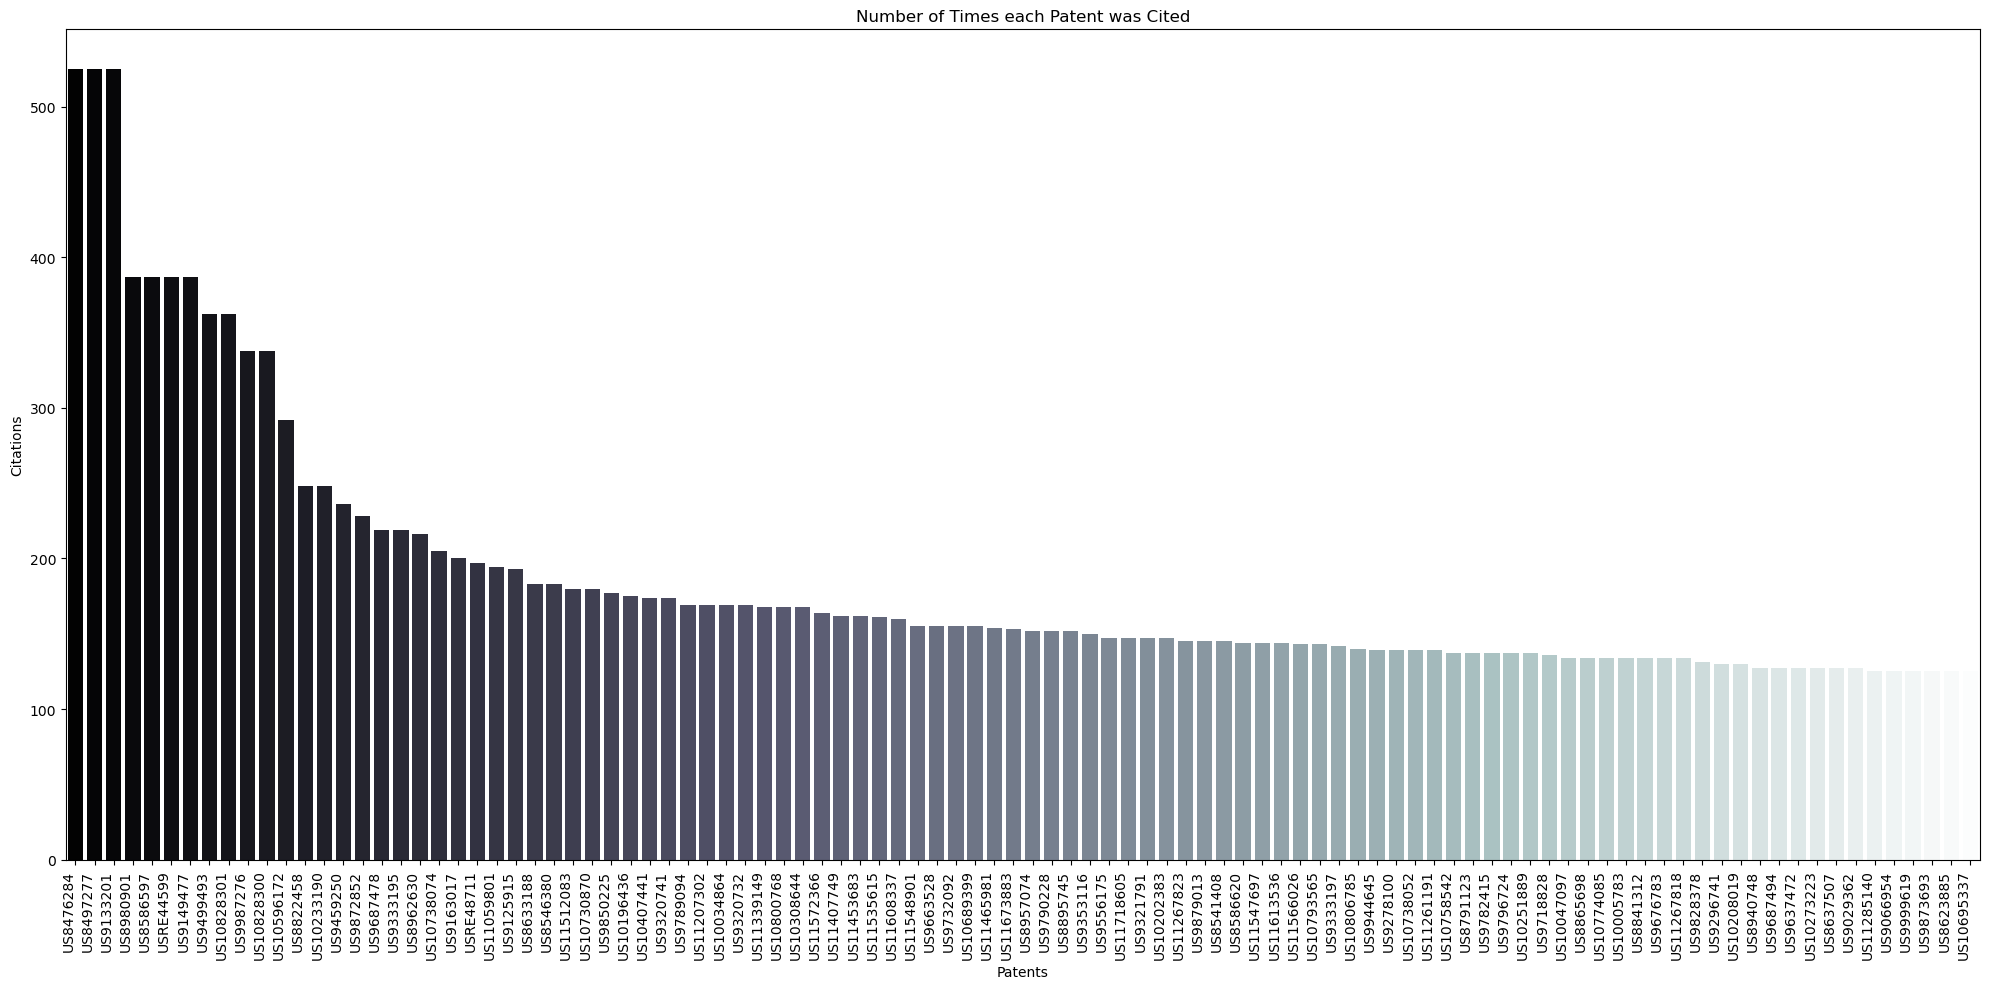

In [65]:
plt.figure(figsize=(20, 10))
sns.barplot(x="patent", y="total citations", data=sorted_top_100, palette="bone")
# total_mean = patents_df["total citations"].mean()
# total_median = patents_df["total citations"].median()
# plt.axhline(total_mean, color='blue', linestyle='--', label=f"Mean: {total_mean:.2f}")
# plt.axhline(total_median, color='blue', linestyle='-', label=f"Median: {total_median:.2f}")
plt.xticks(rotation=90, ha="right")
plt.xlabel("Patents")
plt.ylabel("Citations")
plt.title("Number of Times each Patent was Cited")
plt.tight_layout()
plt.show()

In [22]:
# fig = px.bar(
#     sorted_top_100,
#     x="patent",
#     y="total citations",
#     title="Number of Times each Patent was Cited",
#     labels={"patent": "Patents", "total citations": "Citations"},
#     template="plotly_dark",
#     color_discrete_sequence=px.colors.sequential.Blues_r,
# )
# fig.update_layout(
#     xaxis_title="Patents",
#     yaxis_title="Citations",
#     xaxis_tickangle=-90,
#     xaxis=dict(tickmode='linear')
# )
# fig.show()

# Disease classes:

In [72]:
from src.scripts.disease_plotting import (
    load_uniprotid_diseases,
    quantify_missing_diseases,
    add_keywords_when_comments_missing,
    sort_diseases,
)

diseases = load_uniprotid_diseases()
ids_missing_diseases, percentage_missing = quantify_missing_diseases(diseases)
diseases_df = add_keywords_when_comments_missing(diseases)
diseases_df = diseases_df.rename(columns={"comments_bfill": "diseases"})
diseases_df = diseases_df.dropna(subset="diseases").drop(
    columns=["comments", "keywords"]
)
diseases_df["Disease Classes"] = diseases_df["diseases"].apply(
    lambda l: [sort_diseases(l_i) for l_i in l]
)


def get_patent_citations_per_disease(df, diseases_df, patents_df):
    disease_class_dict = {
        disease_class: set(
            diseases_df[
                diseases_df["Disease Classes"].apply(lambda x: disease_class in x)
            ]["UniProt (SwissProt) Primary ID of Target Chain"]
        )
        for disease_class in set(sum(diseases_df["Disease Classes"], []))
    }
    disease_class_df = pd.DataFrame(
        [
            (disease_class, uniprot_id)
            for disease_class, uniprot_ids in disease_class_dict.items()
            for uniprot_id in uniprot_ids
        ],
        columns=["Disease Classes", "UniProt (SwissProt) Primary ID of Target Chain"],
    )
    bindingDB = df.dropna(subset=["Patent Number"])
    merged_data = bindingDB.merge(
        disease_class_df,
        on="UniProt (SwissProt) Primary ID of Target Chain",
        how="inner",
    )
    disease_patents = (
        merged_data.groupby("Disease Classes")["Patent Number"].apply(set).reset_index()
    )
    disease_patents["Total Citations"] = disease_patents["Patent Number"].apply(
        lambda patents: sum(
            patents_df.loc[patents_df["patent"].isin(patents), "total citations"]
        )
    )
    def get_patent_citations(patents):
        citations = []
        for patent in patents:
            citation_data = patents_df.loc[patents_df["patent"] == patent, "total citations"]
            citation_count = citation_data.iloc[0] if not citation_data.empty else 0
            citations.append({"Patent Number": patent, "Citations": citation_count})
        return citations
    disease_patents["Patent Citations"] = disease_patents["Patent Number"].apply(get_patent_citations)
    
    disease_citations_df = disease_patents.sort_values(
        by="Total Citations", ascending=False
    ).reset_index(drop=True)
    return disease_citations_df

disease_citations_df = get_patent_citations_per_disease(df, diseases_df, patents_df)
disease_citations_df

,Disease Classes,Patent Number,Total Citations,Patent Citations
0,Cancer,"{US8536175, US11691950, US10196390, US9018234,...",34181,"[{'Patent Number': 'US8536175', 'Citations': 1..."
1,Immunodeficiency,"{US20240002404, US10941115, US8470836, US10711...",21048,"[{'Patent Number': 'US20240002404', 'Citations..."
2,Agammaglobulinemia,"{US9353062, US10246457, US8618107, US9951077, ...",7953,"[{'Patent Number': 'US9353062', 'Citations': 1..."
3,Polycythemia vera,"{US20240002404, US9725445, US11427581, US10875...",6487,"[{'Patent Number': 'US20240002404', 'Citations..."
4,Thrombocythemia,"{US20240002404, US9725445, US11427581, US10875...",6487,"[{'Patent Number': 'US20240002404', 'Citations..."
...,...,...,...,...
819,"Charcot-Marie-Tooth disease, recessive interme...",{US20230414632},0,"[{'Patent Number': 'US20230414632', 'Citations..."
820,Transient familial neonatal hyperbilirubinemia,{US11938127},0,"[{'Patent Number': 'US11938127', 'Citations': 0}]"
821,"Neuromyotonia and axonal neuropathy, autosomal...",{US10513520},0,"[{'Patent Number': 'US10513520', 'Citations': 0}]"
822,"Spinocerebellar ataxia, autosomal recessive, 23",{US10617706},0,"[{'Patent Number': 'US10617706', 'Citations': 0}]"


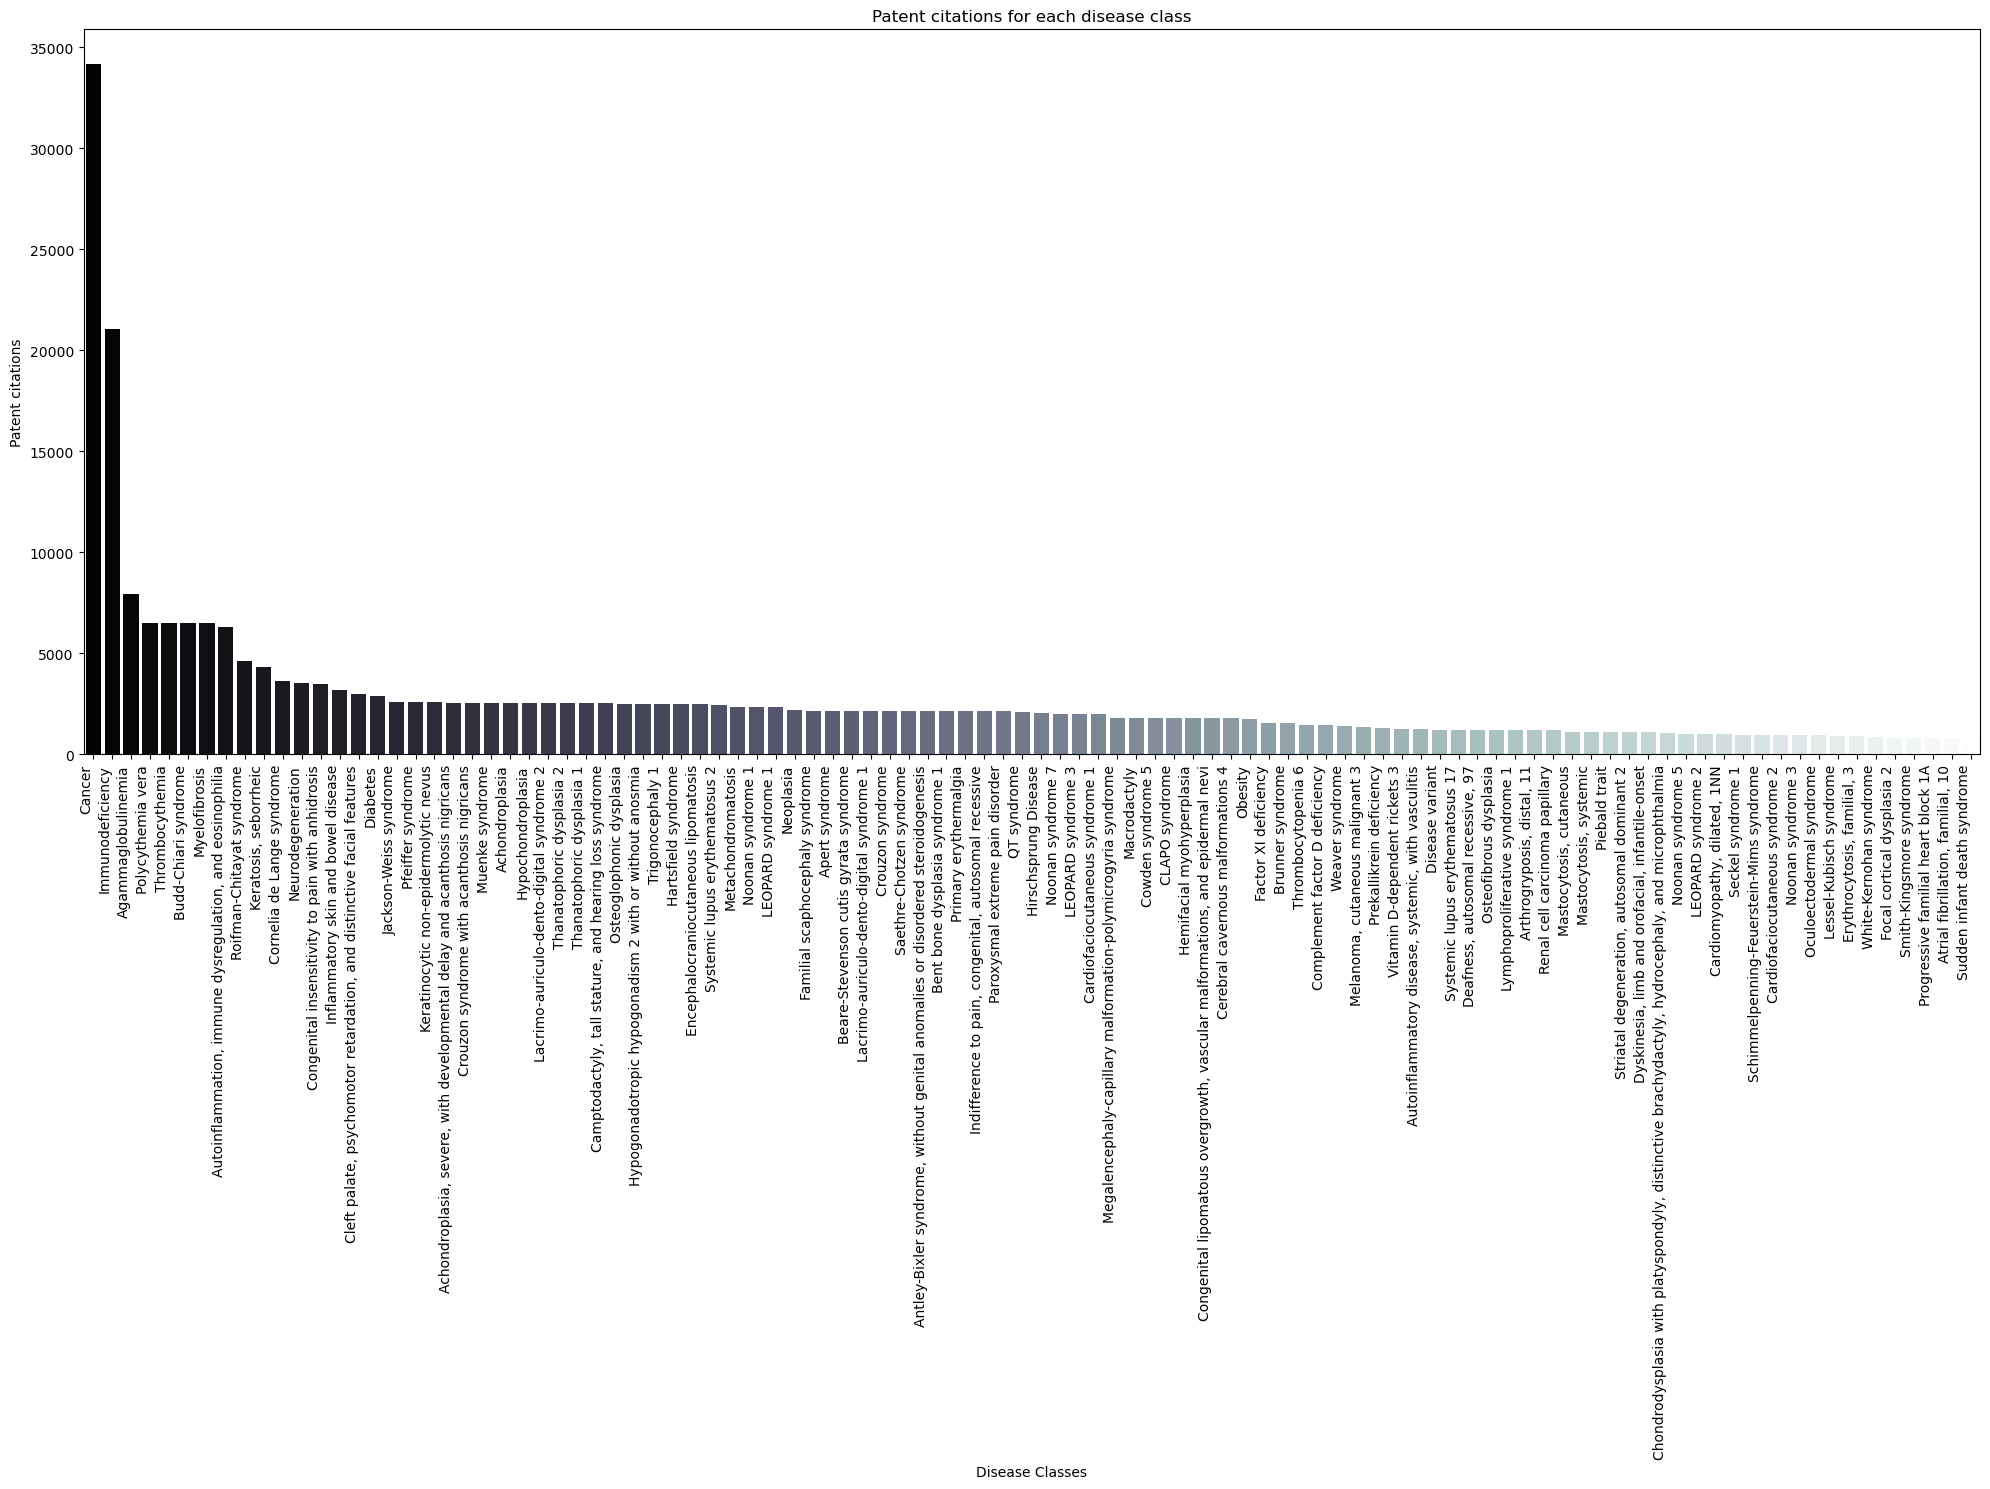

In [73]:
plt.figure(figsize=(20, 15))
sns.barplot(
    x="Disease Classes",
    y="Total Citations",
    data=disease_citations_df.head(100),
    palette="bone",
)
plt.xticks(rotation=90, ha="right")
plt.xlabel("Disease Classes")
plt.ylabel("Patent citations")
plt.title("Patent citations for each disease class")
plt.tight_layout()
plt.show()

In [74]:
disease_citations_df["Disease Classes"] = disease_citations_df["Disease Classes"].replace(
    "Autoinflammation, immune dysregulation, and eosinophilia",
    "Autoinflammation"
)
colors = ['#F0BCD4']
fig = px.bar(
    disease_citations_df.head(10),
    x="Total Citations",
    y="Disease Classes",
    orientation='h',
    title="Patent Citations for each Disease Class",
    color_discrete_sequence=colors
)
fig.update_layout(
    xaxis_title="Patent Citations",
    yaxis_title="Disease Classes",
    xaxis=dict(
        tickmode='linear',
        tick0=0,  
        dtick=5000,  
        tickangle=0
    ),
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark",
)
fig.update_yaxes(
    categoryorder="total ascending",
)
fig.show()

In [75]:
disease_citations_df['Patents Count'] = disease_citations_df['Patent Number'].apply(len)

In [76]:
import plotly.graph_objects as go

disease_citations_df = disease_citations_df.sort_values('Patents Count', ascending=False)
colors = ['#F0BCD4', '#A14A76'] 

fig = go.Figure()
fig.add_trace(
    go.Bar(
        y=disease_citations_df['Disease Classes'][0:10],
        x=disease_citations_df['Total Citations'][0:10],
        name='Total Citations',
        orientation='h',
        marker=dict(color=colors[0]),
        offsetgroup=1
    )
)
fig.add_trace(
    go.Bar(
        y=disease_citations_df['Disease Classes'][0:10],
        x=disease_citations_df['Patents Count'][0:10],
        name='Patents Count',
        orientation='h',
        marker=dict(color=colors[1]),
        offsetgroup=2,
        xaxis='x2'
    )
)
fig.update_layout(
    title="Distribution of Patents and Citations per Disease Class",
    title_x=0.5,
    title_y=0.95,
    yaxis=dict(
        title="Disease Classes",
        categoryorder="array",
        categoryarray=disease_citations_df['Disease Classes'][0:10][::-1] 
    ),
    xaxis=dict(
        title="Total Citations",
        titlefont=dict(color=colors[0]),
        tickfont=dict(color=colors[0])
    ),
    xaxis2=dict(
        title="Patents Count",
        titlefont=dict(color=colors[1]),
        tickfont=dict(color=colors[1]),
        overlaying='x', 
        side='top',
        position=1
    ),
    barmode='group',
    legend=dict(x=1, y=1, traceorder='normal', orientation='v'),
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template='plotly_dark'
)
fig.show()

In [46]:
custom_style = """
<style>
  body, html {
    background-color: rgb(34, 37, 41);
  }
</style>
"""

# Save the HTML file and inject the custom style
html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# Insert the style in the <head>
html_content = html_content.replace("</head>", f"{custom_style}</head>")

# Write to a file
with open("Patents_Diseases.html", "w") as f:
    f.write(html_content)

fig.write_image("Patents_Diseases.svg")

In [77]:
disease_citations_df

,Disease Classes,Patent Number,Total Citations,Patent Citations,Patents Count
0,Cancer,"{US8536175, US11691950, US10196390, US9018234,...",34181,"[{'Patent Number': 'US8536175', 'Citations': 1...",1234
1,Immunodeficiency,"{US20240002404, US10941115, US8470836, US10711...",21048,"[{'Patent Number': 'US20240002404', 'Citations...",719
2,Agammaglobulinemia,"{US9353062, US10246457, US8618107, US9951077, ...",7953,"[{'Patent Number': 'US9353062', 'Citations': 1...",228
11,Neurodegeneration,"{US9096594, US11203601, US9266848, US9212186, ...",3555,"[{'Patent Number': 'US9096594', 'Citations': 2...",224
4,Thrombocythemia,"{US20240002404, US9725445, US11427581, US10875...",6487,"[{'Patent Number': 'US20240002404', 'Citations...",220
...,...,...,...,...,...
643,"Congenital myopathy 22A, classic",{US9675591},9,"[{'Patent Number': 'US9675591', 'Citations': 9}]",1
644,"Congenital myopathy 22B, severe fetal",{US9675591},9,"[{'Patent Number': 'US9675591', 'Citations': 9}]",1
645,"Fanconi anemia, complementation group R",{US11291655},9,"[{'Patent Number': 'US11291655', 'Citations': 9}]",1
646,Spinal muscular atrophy X-linked 2,{US10202389},9,"[{'Patent Number': 'US10202389', 'Citations': 9}]",1


In [ ]:
disease_h_index_exp = []
for index, row in disease_citations_df.iterrows():
    disease_class = row["Disease Classes"]
    citations_counts = [
        entry["Citations"]
        for entry in row["Patent Citations"]
        if entry["Citations"] is not None
    ]
    if citations_counts:
        h_index = sum(
            x >= i + 1 for i, x in enumerate(sorted(citations_counts, reverse=True))
        )
    else:
        h_index = 0
    disease_h_index_exp.append(
        {"Disease Classes": disease_class, "H-Index": h_index}
    )
    disease_h_index_df = pd.DataFrame(disease_h_index_exp)
    disease_h_index_df = disease_h_index_df.sort_values(
            by="H-Index", ascending=False
        )
disease_h_index_df

,Disease Classes,H-Index
0,Cancer,79
1,Immunodeficiency,67
4,Thrombocythemia,45
5,Budd-Chiari syndrome,45
6,Myelofibrosis,45
...,...,...
646,"Myasthenic syndrome, congenital, 21, presynaptic",0
647,"Deafness, autosomal recessive, 89",0
648,"Erythrocytosis, familial, 8",0
649,Crigler-Najjar syndrome 1,0


In [114]:
disease_h_index_df["Disease Classes"] = disease_h_index_df["Disease Classes"].replace(
    "Cleft palate, psychomotor retardation, and distinctive facial features",
    "Psychomotor retardation"
)
colors = ['#DE9151']
fig = px.bar(
    disease_h_index_df[0:10],
    x="H-Index",
    y="Disease Classes",
    orientation='h',
    title="Patent H-Index per Disease Class",
    log_x=True,
    color_discrete_sequence=colors
)
fig.update_layout(
    yaxis_title="Disease Classes",
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark"
)
fig.update_yaxes(categoryorder="total ascending")
fig.show()

In [115]:
custom_style = """
<style>
  body, html {
    background-color: rgb(34, 37, 41);
  }
</style>
"""

# Save the HTML file and inject the custom style
html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# Insert the style in the <head>
html_content = html_content.replace("</head>", f"{custom_style}</head>")

# Write to a file
with open("Patents_HIndex_Diseases.html", "w") as f:
    f.write(html_content)

fig.write_image("Patents_HIndex_Diseases.svg")

In [183]:
disease_citations_df["Patent status"] = disease_citations_df["Patent Number"].apply(
    lambda patents: list(patents_df.loc[patents_df["patent"].isin(patents), "status"])
)
exploded_df = disease_citations_df.head(100).explode("Patent status")
status_counts = (
    exploded_df.groupby(["Disease Classes", "Patent status"])
    .size()
    .unstack(fill_value=0)
)
status_counts = status_counts.drop(columns=["N/A"])
disease_citations_df = disease_citations_df.sort_values(by ="Patents Count", ascending=False)
top_10_diseases = disease_citations_df["Disease Classes"].head(10)
filtered_counts = status_counts.loc[top_10_diseases]
long_data = filtered_counts.reset_index().melt(
    id_vars="Disease Classes", var_name="Patent Status", value_name="Count"
)

In [184]:
fig = px.bar(
    long_data,
    x="Disease Classes",
    y="Count",
    color="Patent Status",
    title="Patent Status for Top 10 Most Cited Diseases",
    color_discrete_sequence=px.colors.sequential.Plasma,
)
fig.update_layout(
    xaxis_title="Disease Classes",
    yaxis_title="Patent Status Counts",
    legend_title="Patent Status",
    barmode="stack",
    xaxis_tickangle=45,
    width=800,
    height=600,
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark"
)
fig.show()

In [185]:
custom_style = """
<style>
  body, html {
    background-color: rgb(34, 37, 41);
  }
</style>
"""

# Save the HTML file and inject the custom style
html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# Insert the style in the <head>
html_content = html_content.replace("</head>", f"{custom_style}</head>")

# Write to a file
with open("Patent_Status_Diseases.html", "w") as f:
    f.write(html_content)

fig.write_image("Patent_Status_Diseases.svg")

In [100]:
# columns_to_plot = [
#     "Active",
#     "Abandoned",
#     "Active - Reinstated",
#     "Ceased",
#     "Expired - Fee Related",
#     "Expired - Lifetime",
#     "Pending",
# ]
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 15))
# axes = axes.flatten()
# for i, column in enumerate(columns_to_plot):
#     if i >= len(axes):
#         break
#     sorted_data = status_counts.sort_values(by=column, ascending=False)
#     sns.barplot(data=sorted_data[column].head(10), palette="bone", ax=axes[i])
#     truncated_labels = [
#         " ".join(label.split()[:3]) for label in sorted_data[column].head(10).index
#     ]
#     axes[i].set_xticklabels(truncated_labels)
#     axes[i].set_title(f"{column} Patent Counts for Top 10 Diseases")
#     axes[i].tick_params(axis="x", rotation=90)
# for j in range(len(columns_to_plot), len(axes)):
#     fig.delaxes(axes[j])
# plt.tight_layout()
# plt.show()

# Target classes:

In [136]:
# importing from scripts
from src.scripts import targets
mapped_names = targets.get_target_class(names_df=df)
merged = df.merge(mapped_names, left_index=True, right_index=True)
merged = merged.dropna(subset="Patent Number")
target_dois = (
    merged.groupby("UniProt (SwissProt) Recommended Name of Target Chain_y")["Patent Number"].apply(set).reset_index()
)
patents_dict = patents_df.set_index('patent')['total citations'].to_dict()
target_citations_exp = []
for index, row in target_dois.iterrows():
    target_class = row['UniProt (SwissProt) Recommended Name of Target Chain_y']
    patents = row["Patent Number"]
    citations_list = []
    for patent in patents: 
        citation_count = patents_dict.get(patent, 0)  # 0 if DOI not found
        citations_list.append({"Patent": patent, "Citations": citation_count})
    target_citations_exp.append(
        {"Target Classes": target_class, "Citations": citations_list}
    )
target_citations_df = pd.DataFrame(target_citations_exp)

In [137]:
target_h_index_exp = []
for index, row in target_citations_df.iterrows():
    target_class = row["Target Classes"]
    citations_counts = [
        entry["Citations"]
        for entry in row["Citations"]
        if entry["Citations"] is not None
    ]
    if citations_counts:
        h_index = sum(
            x >= i + 1 for i, x in enumerate(sorted(citations_counts, reverse=True))
        )
    else:
        h_index = 0
    target_h_index_exp.append(
        {"Target Classes": target_class, "H-Index": h_index}
    )
    target_h_index_df = pd.DataFrame(target_h_index_exp)
    target_h_index_df = target_h_index_df.sort_values(
            by="H-Index", ascending=False
        )
target_h_index_df

,Target Classes,H-Index
678,Non Receptor Tyr Kinase,68
436,Growth Factor Receptor,64
460,Histone Modifier,47
698,Other Protein Kinase,47
516,Ion Channel,40
...,...,...
1098,Tyrosine-protein phosphatase non-receptor type 12,0
52,Activating signal cointegrator 1 complex subun...,0
692,Nuclear receptor subfamily 2 group E member 1,0
1142,Vesicular acetylcholine transporter,0


In [124]:
colors = ['#6F584B']
fig = px.bar(
    target_h_index_df[0:10],
    x="H-Index",
    y="Target Classes",
    orientation='h',
    title="Patent H-Index per Target Class",
    log_x=True,
    color_discrete_sequence=colors
)
fig.update_layout(
    yaxis_title="Target Classes",
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark"
)
fig.update_yaxes(categoryorder="total ascending")
fig.show()

In [120]:
custom_style = """
<style>
  body, html {
    background-color: rgb(34, 37, 41);
  }
</style>
"""

# Save the HTML file and inject the custom style
html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# Insert the style in the <head>
html_content = html_content.replace("</head>", f"{custom_style}</head>")

# Write to a file
with open("Patents_HIndex_Target.html", "w") as f:
    f.write(html_content)

fig.write_image("Patents_HIndex_Target.svg")

In [138]:
target_citations_df["Patent Count"] = target_citations_df["Citations"].apply(len)
target_citations_df["Total Citations"] = target_citations_df["Citations"].apply(
    lambda citations: sum(citation.get("Citations", 0) or 0 for citation in citations)
)
target_citations_df

,Target Classes,Citations,Patent Count,Total Citations
0,"1,3-beta-glucan synthase","[{'Patent': 'US8624022', 'Citations': 10}]",1,10
1,"1,5-anhydro-D-fructose reductase","[{'Patent': 'US9718813', 'Citations': 3}]",1,3
2,11-beta-hydroxysteroid dehydrogenase 1,"[{'Patent': 'US9120769', 'Citations': 11}, {'P...",18,326
3,11-beta-hydroxysteroid dehydrogenase type 2,"[{'Patent': 'US11858959', 'Citations': 0}, {'P...",2,3
4,17-beta-hydroxysteroid dehydrogenase 13,"[{'Patent': 'US20230416268', 'Citations': 0}, ...",4,12
...,...,...,...,...
1163,fMet-Leu-Phe receptor,"[{'Patent': 'US11124494', 'Citations': 7}, {'P...",11,67
1164,"glucan 1,4-alpha-glucosidase","[{'Patent': 'US11292789', 'Citations': 0}]",1,0
1165,non-specific protein-tyrosine kinase,"[{'Patent': 'US9670214', 'Citations': 60}]",1,60
1166,receptor protein-tyrosine kinase,"[{'Patent': 'US11214566', 'Citations': 5}, {'P...",3,15


In [139]:
target_sorted_citations = target_citations_df.sort_values(by="Total Citations", ascending=False)
target_sorted_patents = target_citations_df.sort_values(by="Patent Count", ascending=False)

In [143]:
top_10_citations = target_sorted_citations.head(10)
top_10_patents = target_sorted_patents.head(10)
top_10_union = pd.concat([top_10_citations['Target Classes'], top_10_patents['Target Classes']]).drop_duplicates()
top_10_union.reset_index(drop=True, inplace=True)
corresp_citations = target_sorted_citations[target_sorted_citations['Target Classes'].isin(top_10_union)]
corresp_patents = target_sorted_patents[target_sorted_patents['Target Classes'].isin(top_10_union)]
union = pd.concat([corresp_citations, corresp_patents]).drop_duplicates(subset='Target Classes')
union.reset_index(drop=True, inplace=True)
union = union.sort_values(by="Patent Count", ascending=False)
union

,Target Classes,Citations,Patent Count,Total Citations
0,Non Receptor Tyr Kinase,"[{'Patent': 'US20240002404', 'Citations': 2}, ...",618,19967
2,Other Protein Kinase,"[{'Patent': 'US11203601', 'Citations': 3}, {'P...",465,10027
1,Growth Factor Receptor,"[{'Patent': 'US9750744', 'Citations': 107}, {'...",437,13228
8,Neurotransmitter receptor,"[{'Patent': 'US9714232', 'Citations': 14}, {'P...",317,3202
5,Ion Channel,"[{'Patent': 'US10221177', 'Citations': 16}, {'...",311,5606
3,Histone Modifier,"[{'Patent': 'US9718814', 'Citations': 30}, {'P...",285,7731
6,Phosphodiesterase,"[{'Patent': 'US9062059', 'Citations': 18}, {'P...",246,3600
4,Phosphatidylinositol Kinase,"[{'Patent': 'US11077113', 'Citations': 9}, {'P...",186,5795
11,Hormone Receptor,"[{'Patent': 'US10172814', 'Citations': 5}, {'P...",185,2845
10,Polyprotein,"[{'Patent': 'US11124497', 'Citations': 36}, {'...",139,3080


In [190]:
import pandas as pd
import plotly.graph_objects as go

colors = ["#ABC4AB", "#FF785A"]

fig = go.Figure()
fig.add_trace(
    go.Bar(
        y=union['Target Classes'],
        x=union['Total Citations'],
        name='Total Citations',
        orientation='h',
        marker=dict(color=colors[0]),
        offsetgroup=1
    )
)
fig.add_trace(
    go.Bar(
        y=union['Target Classes'],
        x=union['Patent Count'],
        name='Patent Count',
        orientation='h',
        marker=dict(color=colors[1]),
        offsetgroup=2,
        xaxis='x2'
    )
)
fig.update_layout(
    title="Distribution of Patents and Citations per Target Class",
    title_x=0.5,
    title_y=0.95,
    yaxis=dict(
        title="Target Classes",
        categoryorder="array",
        categoryarray=union['Target Classes'][::-1] 
    ),
    xaxis=dict(
        title="Total Citations",
        titlefont=dict(color=colors[0]),
        tickfont=dict(color=colors[0])
    ),
    xaxis2=dict(
        title="Patent Count",
        titlefont=dict(color=colors[1]),
        tickfont=dict(color=colors[1]),
        overlaying='x', 
        side='top',
        position=1
    ),
    barmode='group',
    legend=dict(x=1, y=1, traceorder='normal', orientation='v'),
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template='plotly_dark'
)
fig.show()

In [191]:
custom_style = """
<style>
  body, html {
    background-color: rgb(34, 37, 41);
  }
</style>
"""

# Save the HTML file and inject the custom style
html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# Insert the style in the <head>
html_content = html_content.replace("</head>", f"{custom_style}</head>")

# Write to a file
with open("Patents_Citations_Target.html", "w") as f:
    f.write(html_content)

fig.write_image("Patents_Citations_Target.svg")

In [159]:
target_citations_df['Patent Number'] = target_citations_df['Citations'].apply(lambda citations: [citation['Patent'] for citation in citations])

In [ ]:
target_citations_df["Patent status"] = target_citations_df["Patent Number"].apply(
    lambda patents: list(patents_df.loc[patents_df["patent"].isin(patents), "status"])
)
exploded_df = target_citations_df.head(100).explode("Patent status")
status_counts = (
    exploded_df.groupby(["Target Classes", "Patent status"])
    .size()
    .unstack(fill_value=0)
)
top_10_targets = target_citations_df["Target Classes"].head(10)
filtered_counts = status_counts.loc[top_10_targets]
long_data = filtered_counts.reset_index().melt(
    id_vars="Target Classes", var_name="Patent Status", value_name="Count"
)

In [ ]:
fig = px.bar(
    long_data,
    x="Target Classes",
    y="Count",
    color="Patent Status",
    title="Patent Status for Top 10 Most Cited Target Classes",
)
fig.update_layout(
    xaxis_title="Target Classes",
    yaxis_title="Patent Status Counts",
    legend_title="Patent Status",
    barmode="stack",
    xaxis_tickangle=45,
    width=800,
    height=600,
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark"
)
fig.show()

In [186]:
custom_style = """
<style>
  body, html {
    background-color: rgb(34, 37, 41);
  }
</style>
"""

# Save the HTML file and inject the custom style
html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# Insert the style in the <head>
html_content = html_content.replace("</head>", f"{custom_style}</head>")

# Write to a file
with open("Patent_Status_Target.html", "w") as f:
    f.write(html_content)

fig.write_image("Patent_Status_Target.svg")